In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable

In [2]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        # 加载数据集文件
        self.data = []
        with open('./data/insects-' + file_path, 'r') as file:
            for line in file:
                # 将每一行的特征和标签提取出来并转换成对应的类型
                feature1, feature2, label = line.strip().split()
                self.data.append((float(feature1), float(feature2), int(label)))
        with open('./data/insects-2-' + file_path, 'r') as file:
            for line in file:
                # 将每一行的特征和标签提取出来并转换成对应的类型
                feature1, feature2, label = line.strip().split()
                self.data.append((float(feature1), float(feature2), int(label)))
    
    def __len__(self):
        # 返回数据集的大小
        return len(self.data)
    
    def __getitem__(self, index):
        # 根据索引返回对应的特征和标签
        feature1, feature2, label = self.data[index]
        feature = []
        feature.append(feature1)
        feature.append(feature2)
        feature = np.array(feature).reshape(2,1)
        return torch.tensor(label), torch.tensor([feature1, feature2],dtype=torch.float32)




In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),nn.ReLU(),
            nn.Linear(10, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 100),nn.ReLU(),
            nn.Linear(100, 10),nn.ReLU(),
            nn.Linear(10, 3)
        )
        
    def forward(self, input):
        return self.net(input)

In [4]:


class Model(object):

    def __init__(self, batch_size=64, num_workers=10, seed=0, save = False):
        super(Model, self).__init__()

        train_dataset = MyDataset('training.txt')
        test_dataset = MyDataset('testing.txt')

        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
        self.test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

        self.net = None
        self.lr = None
        self.optimizer = None
        self.device = "cuda"
        self.schedule = None
        self.fig_name = None
        self.save = save
        self.loss_list = {"train": [], "val": [],"tacc":[],"acc":[]}

    def train(self, lr=0.01, epochs=10, device="cpu", wait=8, lrd=False, fig_name="test"):
        self.device = torch.device(device) if torch.cuda.is_available() else torch.device("cpu")
        self.lr = lr
        self.fig_name = fig_name
        self.net = Net().to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        if lrd:
            self.schedule = ReduceLROnPlateau(self.optimizer, 'min', patience=10, verbose=True)

        #os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
        total_params = sum([param.nelement() for param in self.net.parameters() if param.requires_grad])

        print(">>> Total params: {}".format(total_params))

        print(">>> Start training")
        min_val_loss = np.inf
        min_val_loss_acc = 0.0
        delay = 0
        for epoch in range(epochs):

            # train train data
            for data in tqdm(self.train_dataloader):
                labels, inputs = data
                #labels = Variable(labels)-1
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                self.optimizer.step()
               
            # calc train loss and train acc
            train_loss = 0.0
            val_loss = 0.0
            val_acc = 0.0
            train_acc = 0.0
            with torch.no_grad():
                for data in self.train_dataloader:
                    labels, inputs = data
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.net(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)

                    train_loss += loss.item()
                    train_acc += self.acc(labels=labels.cpu().numpy(), outputs=outputs.detach().cpu().numpy())
            
                train_acc = train_acc / len(self.train_dataloader)

                train_loss = train_loss / len(self.train_dataloader)
                
                self.loss_list['train'].append(train_loss)
                self.loss_list['tacc'].append(train_acc)

                for data in self.test_dataloader:
                    labels, inputs = data
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.net(inputs)
                    
                    loss = nn.CrossEntropyLoss()(outputs, labels)

                    val_loss += loss.item()
                    val_acc += self.acc(labels=labels.cpu().numpy(), outputs=outputs.detach().cpu().numpy())
                val_loss = val_loss / len(self.test_dataloader)
                val_acc = val_acc / len(self.test_dataloader)
                self.loss_list['acc'].append(val_acc)
                self.loss_list['val'].append(val_loss)
                print(f"Epoch {epoch}: train loss {train_loss:10.6f}, "
                      f"val loss {val_loss:10.6f}",f"val_acc {val_acc},"
                     f"train_acc {train_acc}")
            # if necessary, reduce the learning rate by val loss
            if lrd:
                self.schedule.step(val_loss)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                min_val_loss_acc = val_acc
                print(f"Update min_val_loss to {min_val_loss:10.6f}")
                delay = 0
            else:
                delay = delay + 1

            if delay > wait:
                break
        if self.save == True:
            print('save model')
            torch.save({'model': self.net.state_dict()}, 'net.pth')
        print(">>> Finished training")
        self.plot_loss()
        self.plot_acc()
        print(">>> Finished plot loss")
        return min_val_loss_acc

    def test(self):
        
        test_data_loader = self.test_dataloader

        test_acc = 0.0
        for data in test_data_loader:
            labels, inputs = data
            inputs = inputs.to(self.device)
            outputs = self.net(inputs)

            test_acc += self.acc(labels.numpy(), outputs.detach().cpu().numpy())
            
        test_acc = test_acc / len(test_data_loader)

        return test_acc

    def acc(self, labels, outputs, type_="top1"):
        acc = 0
        if type_ == "top1":
            pre_labels = np.argmax(outputs, axis=1)
            labels = labels.reshape(len(labels))
            acc = np.sum(pre_labels == labels) / len(pre_labels)

        return acc

    def setup_seed(self):
        seed = self.seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        torch.cuda.manual_seed(seed)
        random.seed(seed)

    def plot_loss(self):
        plt.figure()
        train_loss = self.loss_list['train']
        val_loss = self.loss_list['val']
        plt.plot(train_loss, c="red", label="train_loss")
        plt.plot(val_loss, c="blue", label="val_loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("CrossEntropyLoss")
        plt.title("CrossEntropyLoss of Train and Validation in each Epoch")
        plt.savefig(f"./fig/{self.fig_name}_loss.png")
        
    def plot_acc(self):
        plt.figure()
        acc = self.loss_list['acc']
        tacc = self.loss_list['tacc']
        plt.plot(acc, c="red", label="val_acc")
        plt.plot(tacc, c="blue", label="train_acc")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("acc")
        plt.title("val_acc")
        plt.savefig(f"./fig/{self.fig_name}_acc.png")


>>> Total params: 72873
>>> Start training


100%|██████████| 113/113 [00:00<00:00, 268.14it/s]


Epoch 0: train loss   0.972983, val loss   0.945103 val_acc 0.5778301886792453,train_acc 0.5597345132743363
Update min_val_loss to   0.945103


100%|██████████| 113/113 [00:00<00:00, 270.77it/s]


Epoch 1: train loss   0.934207, val loss   0.886773 val_acc 0.625,train_acc 0.5873893805309734
Update min_val_loss to   0.886773


100%|██████████| 113/113 [00:00<00:00, 266.96it/s]


Epoch 2: train loss   0.930705, val loss   0.909337 val_acc 0.5966981132075472,train_acc 0.5719026548672567


100%|██████████| 113/113 [00:00<00:00, 268.80it/s]


Epoch 3: train loss   0.838428, val loss   0.825887 val_acc 0.5990566037735849,train_acc 0.5907079646017699
Update min_val_loss to   0.825887


100%|██████████| 113/113 [00:00<00:00, 271.90it/s]


Epoch 4: train loss   0.832542, val loss   0.826630 val_acc 0.5636792452830188,train_acc 0.5796460176991151


100%|██████████| 113/113 [00:00<00:00, 274.11it/s]


Epoch 5: train loss   0.770090, val loss   0.772363 val_acc 0.7429245283018868,train_acc 0.7621681415929203
Update min_val_loss to   0.772363


100%|██████████| 113/113 [00:00<00:00, 271.33it/s]


Epoch 6: train loss   0.700379, val loss   0.696053 val_acc 0.785377358490566,train_acc 0.7953539823008849
Update min_val_loss to   0.696053


100%|██████████| 113/113 [00:00<00:00, 271.15it/s]


Epoch 7: train loss   0.700454, val loss   0.732618 val_acc 0.7051886792452831,train_acc 0.7123893805309734


100%|██████████| 113/113 [00:00<00:00, 283.03it/s]


Epoch 8: train loss   0.577707, val loss   0.588857 val_acc 0.7617924528301887,train_acc 0.7676991150442478
Update min_val_loss to   0.588857


100%|██████████| 113/113 [00:00<00:00, 292.94it/s]


Epoch 9: train loss   0.627640, val loss   0.581248 val_acc 0.7004716981132075,train_acc 0.6792035398230089
Update min_val_loss to   0.581248


100%|██████████| 113/113 [00:00<00:00, 289.64it/s]


Epoch 10: train loss   0.527703, val loss   0.554775 val_acc 0.7877358490566038,train_acc 0.797566371681416
Update min_val_loss to   0.554775


100%|██████████| 113/113 [00:00<00:00, 297.85it/s]


Epoch 11: train loss   0.576177, val loss   0.619946 val_acc 0.7759433962264151,train_acc 0.7842920353982301


100%|██████████| 113/113 [00:00<00:00, 248.26it/s]


Epoch 12: train loss   0.564011, val loss   0.564281 val_acc 0.7617924528301887,train_acc 0.754424778761062


100%|██████████| 113/113 [00:00<00:00, 293.54it/s]


Epoch 13: train loss   0.557332, val loss   0.527541 val_acc 0.7806603773584906,train_acc 0.7433628318584071
Update min_val_loss to   0.527541


100%|██████████| 113/113 [00:00<00:00, 274.33it/s]


Epoch 14: train loss   0.577158, val loss   0.550669 val_acc 0.7877358490566038,train_acc 0.7732300884955752


100%|██████████| 113/113 [00:00<00:00, 293.88it/s]


Epoch 15: train loss   0.492036, val loss   0.526856 val_acc 0.8066037735849056,train_acc 0.8241150442477876
Update min_val_loss to   0.526856


100%|██████████| 113/113 [00:00<00:00, 290.64it/s]


Epoch 16: train loss   0.536446, val loss   0.563214 val_acc 0.7617924528301887,train_acc 0.7610619469026548


100%|██████████| 113/113 [00:00<00:00, 296.66it/s]


Epoch 17: train loss   0.483549, val loss   0.488277 val_acc 0.8042452830188679,train_acc 0.8263274336283186
Update min_val_loss to   0.488277


100%|██████████| 113/113 [00:00<00:00, 301.38it/s]


Epoch 18: train loss   0.480051, val loss   0.524957 val_acc 0.8254716981132075,train_acc 0.8329646017699115


100%|██████████| 113/113 [00:00<00:00, 288.95it/s]


Epoch 19: train loss   0.560038, val loss   0.518113 val_acc 0.7830188679245284,train_acc 0.7555309734513275


100%|██████████| 113/113 [00:00<00:00, 289.19it/s]


Epoch 20: train loss   0.491648, val loss   0.496289 val_acc 0.8325471698113207,train_acc 0.8174778761061947


100%|██████████| 113/113 [00:00<00:00, 290.09it/s]


Epoch 21: train loss   0.560464, val loss   0.488939 val_acc 0.7995283018867925,train_acc 0.7356194690265486


100%|██████████| 113/113 [00:00<00:00, 285.18it/s]


Epoch 22: train loss   0.533585, val loss   0.539744 val_acc 0.7877358490566038,train_acc 0.754424778761062


100%|██████████| 113/113 [00:00<00:00, 277.86it/s]


Epoch 23: train loss   0.439557, val loss   0.424458 val_acc 0.8537735849056604,train_acc 0.8296460176991151
Update min_val_loss to   0.424458


100%|██████████| 113/113 [00:00<00:00, 285.03it/s]


Epoch 24: train loss   0.334821, val loss   0.363731 val_acc 0.8844339622641509,train_acc 0.9004424778761062
Update min_val_loss to   0.363731


100%|██████████| 113/113 [00:00<00:00, 288.13it/s]


Epoch 25: train loss   0.317029, val loss   0.320663 val_acc 0.8985849056603774,train_acc 0.9026548672566371
Update min_val_loss to   0.320663


100%|██████████| 113/113 [00:00<00:00, 297.83it/s]


Epoch 26: train loss   0.338145, val loss   0.351813 val_acc 0.8702830188679245,train_acc 0.8772123893805309


100%|██████████| 113/113 [00:00<00:00, 280.86it/s]


Epoch 27: train loss   0.298665, val loss   0.256277 val_acc 0.910377358490566,train_acc 0.8982300884955752
Update min_val_loss to   0.256277


100%|██████████| 113/113 [00:00<00:00, 288.12it/s]


Epoch 28: train loss   0.344099, val loss   0.341414 val_acc 0.8608490566037735,train_acc 0.8672566371681416


100%|██████████| 113/113 [00:00<00:00, 298.57it/s]


Epoch 29: train loss   0.305655, val loss   0.284410 val_acc 0.8702830188679245,train_acc 0.8882743362831859


100%|██████████| 113/113 [00:00<00:00, 294.44it/s]


Epoch 30: train loss   0.412141, val loss   0.282576 val_acc 0.8962264150943396,train_acc 0.8241150442477876


100%|██████████| 113/113 [00:00<00:00, 297.67it/s]


Epoch 31: train loss   0.369087, val loss   0.270464 val_acc 0.9033018867924528,train_acc 0.8584070796460177


100%|██████████| 113/113 [00:00<00:00, 297.01it/s]


Epoch 32: train loss   0.364052, val loss   0.322288 val_acc 0.8655660377358491,train_acc 0.875


100%|██████████| 113/113 [00:00<00:00, 286.53it/s]


Epoch 33: train loss   0.317845, val loss   0.303741 val_acc 0.875,train_acc 0.8727876106194691


100%|██████████| 113/113 [00:00<00:00, 297.66it/s]


Epoch 34: train loss   0.290809, val loss   0.225265 val_acc 0.910377358490566,train_acc 0.8738938053097345
Update min_val_loss to   0.225265


100%|██████████| 113/113 [00:00<00:00, 291.68it/s]


Epoch 35: train loss   0.278413, val loss   0.216815 val_acc 0.9174528301886793,train_acc 0.8893805309734514
Update min_val_loss to   0.216815


100%|██████████| 113/113 [00:00<00:00, 276.04it/s]


Epoch 36: train loss   0.231820, val loss   0.182342 val_acc 0.9339622641509434,train_acc 0.9026548672566371
Update min_val_loss to   0.182342


100%|██████████| 113/113 [00:00<00:00, 289.93it/s]


Epoch 37: train loss   0.234911, val loss   0.200453 val_acc 0.9127358490566038,train_acc 0.9026548672566371


100%|██████████| 113/113 [00:00<00:00, 288.81it/s]


Epoch 38: train loss   0.219959, val loss   0.201767 val_acc 0.9056603773584906,train_acc 0.9048672566371682


100%|██████████| 113/113 [00:00<00:00, 288.65it/s]


Epoch 39: train loss   0.219129, val loss   0.198524 val_acc 0.9056603773584906,train_acc 0.9048672566371682


100%|██████████| 113/113 [00:00<00:00, 277.79it/s]


Epoch 40: train loss   0.231056, val loss   0.207223 val_acc 0.8915094339622641,train_acc 0.9148230088495575


100%|██████████| 113/113 [00:00<00:00, 294.76it/s]


Epoch 41: train loss   0.211392, val loss   0.183805 val_acc 0.9268867924528302,train_acc 0.9092920353982301


100%|██████████| 113/113 [00:00<00:00, 289.86it/s]


Epoch 42: train loss   0.211986, val loss   0.185453 val_acc 0.9127358490566038,train_acc 0.9103982300884956


100%|██████████| 113/113 [00:00<00:00, 294.13it/s]


Epoch 43: train loss   0.264437, val loss   0.178836 val_acc 0.9292452830188679,train_acc 0.8628318584070797
Update min_val_loss to   0.178836


100%|██████████| 113/113 [00:00<00:00, 291.65it/s]


Epoch 44: train loss   0.207346, val loss   0.145759 val_acc 0.9410377358490566,train_acc 0.915929203539823
Update min_val_loss to   0.145759


100%|██████████| 113/113 [00:00<00:00, 290.44it/s]


Epoch 45: train loss   0.215228, val loss   0.231351 val_acc 0.8891509433962265,train_acc 0.9137168141592921


100%|██████████| 113/113 [00:00<00:00, 296.23it/s]


Epoch 46: train loss   0.244023, val loss   0.292029 val_acc 0.8679245283018868,train_acc 0.9004424778761062


100%|██████████| 113/113 [00:00<00:00, 289.72it/s]


Epoch 47: train loss   0.203444, val loss   0.151403 val_acc 0.9481132075471698,train_acc 0.918141592920354


100%|██████████| 113/113 [00:00<00:00, 281.99it/s]


Epoch 48: train loss   0.184094, val loss   0.150152 val_acc 0.9457547169811321,train_acc 0.918141592920354


100%|██████████| 113/113 [00:00<00:00, 291.46it/s]


Epoch 49: train loss   0.196075, val loss   0.160805 val_acc 0.9245283018867925,train_acc 0.9103982300884956


100%|██████████| 113/113 [00:00<00:00, 293.87it/s]


Epoch 50: train loss   0.196258, val loss   0.150197 val_acc 0.9363207547169812,train_acc 0.9148230088495575


100%|██████████| 113/113 [00:00<00:00, 286.39it/s]


Epoch 51: train loss   0.209315, val loss   0.128957 val_acc 0.9457547169811321,train_acc 0.9004424778761062
Update min_val_loss to   0.128957


100%|██████████| 113/113 [00:00<00:00, 307.20it/s]


Epoch 52: train loss   0.199036, val loss   0.178406 val_acc 0.9363207547169812,train_acc 0.911504424778761


100%|██████████| 113/113 [00:00<00:00, 300.69it/s]


Epoch 53: train loss   0.172658, val loss   0.157290 val_acc 0.9339622641509434,train_acc 0.9314159292035398


100%|██████████| 113/113 [00:00<00:00, 302.43it/s]


Epoch 54: train loss   0.214946, val loss   0.138559 val_acc 0.9481132075471698,train_acc 0.9203539823008849


100%|██████████| 113/113 [00:00<00:00, 295.86it/s]


Epoch 55: train loss   0.194387, val loss   0.187488 val_acc 0.8985849056603774,train_acc 0.9137168141592921


100%|██████████| 113/113 [00:00<00:00, 291.47it/s]


Epoch 56: train loss   0.170431, val loss   0.147098 val_acc 0.9386792452830188,train_acc 0.9303097345132744


100%|██████████| 113/113 [00:00<00:00, 285.07it/s]


Epoch 57: train loss   0.191898, val loss   0.123989 val_acc 0.9575471698113207,train_acc 0.9258849557522124
Update min_val_loss to   0.123989


100%|██████████| 113/113 [00:00<00:00, 292.26it/s]


Epoch 58: train loss   0.161370, val loss   0.125325 val_acc 0.9575471698113207,train_acc 0.9469026548672567


100%|██████████| 113/113 [00:00<00:00, 300.97it/s]


Epoch 59: train loss   0.183244, val loss   0.152682 val_acc 0.9386792452830188,train_acc 0.9325221238938053


100%|██████████| 113/113 [00:00<00:00, 289.99it/s]


Epoch 60: train loss   0.188095, val loss   0.169285 val_acc 0.9410377358490566,train_acc 0.9314159292035398


100%|██████████| 113/113 [00:00<00:00, 296.08it/s]


Epoch 61: train loss   0.195725, val loss   0.134226 val_acc 0.9551886792452831,train_acc 0.922566371681416


100%|██████████| 113/113 [00:00<00:00, 298.43it/s]


Epoch 62: train loss   0.203673, val loss   0.154622 val_acc 0.9339622641509434,train_acc 0.922566371681416


100%|██████████| 113/113 [00:00<00:00, 290.55it/s]


Epoch 63: train loss   0.183843, val loss   0.149344 val_acc 0.9268867924528302,train_acc 0.9314159292035398


100%|██████████| 113/113 [00:00<00:00, 289.22it/s]


Epoch 64: train loss   0.184896, val loss   0.164313 val_acc 0.9386792452830188,train_acc 0.9292035398230089


100%|██████████| 113/113 [00:00<00:00, 294.91it/s]


Epoch 65: train loss   0.169191, val loss   0.124399 val_acc 0.9622641509433962,train_acc 0.9380530973451328


100%|██████████| 113/113 [00:00<00:00, 293.04it/s]


Epoch 66: train loss   0.186533, val loss   0.150149 val_acc 0.9410377358490566,train_acc 0.9292035398230089


100%|██████████| 113/113 [00:00<00:00, 296.00it/s]


Epoch 67: train loss   0.201073, val loss   0.175555 val_acc 0.9174528301886793,train_acc 0.9269911504424779


100%|██████████| 113/113 [00:00<00:00, 287.92it/s]


Epoch 68: train loss   0.200866, val loss   0.158056 val_acc 0.9198113207547169,train_acc 0.9203539823008849
Epoch    69: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 113/113 [00:00<00:00, 294.63it/s]


Epoch 69: train loss   0.151887, val loss   0.111345 val_acc 0.9669811320754716,train_acc 0.9480088495575221
Update min_val_loss to   0.111345


100%|██████████| 113/113 [00:00<00:00, 286.06it/s]


Epoch 70: train loss   0.145886, val loss   0.109486 val_acc 0.9693396226415094,train_acc 0.952433628318584
Update min_val_loss to   0.109486


100%|██████████| 113/113 [00:00<00:00, 292.21it/s]


Epoch 71: train loss   0.143232, val loss   0.104647 val_acc 0.9740566037735849,train_acc 0.9535398230088495
Update min_val_loss to   0.104647


100%|██████████| 113/113 [00:00<00:00, 288.56it/s]


Epoch 72: train loss   0.143218, val loss   0.113879 val_acc 0.9669811320754716,train_acc 0.9491150442477876


100%|██████████| 113/113 [00:00<00:00, 298.32it/s]


Epoch 73: train loss   0.139277, val loss   0.105702 val_acc 0.964622641509434,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 288.37it/s]


Epoch 74: train loss   0.138379, val loss   0.098802 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Update min_val_loss to   0.098802


100%|██████████| 113/113 [00:00<00:00, 296.93it/s]


Epoch 75: train loss   0.142552, val loss   0.098389 val_acc 0.9740566037735849,train_acc 0.9502212389380531
Update min_val_loss to   0.098389


100%|██████████| 113/113 [00:00<00:00, 295.75it/s]


Epoch 76: train loss   0.137900, val loss   0.103846 val_acc 0.9693396226415094,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 295.24it/s]


Epoch 77: train loss   0.136361, val loss   0.103868 val_acc 0.9575471698113207,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 296.15it/s]


Epoch 78: train loss   0.135795, val loss   0.097001 val_acc 0.9787735849056604,train_acc 0.9513274336283186
Update min_val_loss to   0.097001


100%|██████████| 113/113 [00:00<00:00, 294.70it/s]


Epoch 79: train loss   0.134479, val loss   0.097890 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 300.50it/s]


Epoch 80: train loss   0.134447, val loss   0.101523 val_acc 0.964622641509434,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 287.82it/s]


Epoch 81: train loss   0.133600, val loss   0.094512 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Update min_val_loss to   0.094512


100%|██████████| 113/113 [00:00<00:00, 300.56it/s]


Epoch 82: train loss   0.135607, val loss   0.110266 val_acc 0.9504716981132075,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 301.02it/s]


Epoch 83: train loss   0.134351, val loss   0.096026 val_acc 0.9740566037735849,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 301.00it/s]


Epoch 84: train loss   0.133808, val loss   0.095649 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.29it/s]


Epoch 85: train loss   0.139012, val loss   0.102604 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 301.17it/s]


Epoch 86: train loss   0.134131, val loss   0.097040 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.43it/s]


Epoch 87: train loss   0.132527, val loss   0.091722 val_acc 0.9787735849056604,train_acc 0.9535398230088495
Update min_val_loss to   0.091722


100%|██████████| 113/113 [00:00<00:00, 298.37it/s]


Epoch 88: train loss   0.133945, val loss   0.097869 val_acc 0.9716981132075472,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 295.76it/s]


Epoch 89: train loss   0.136981, val loss   0.104774 val_acc 0.9599056603773585,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 295.21it/s]


Epoch 90: train loss   0.132220, val loss   0.090334 val_acc 0.9787735849056604,train_acc 0.9535398230088495
Update min_val_loss to   0.090334


100%|██████████| 113/113 [00:00<00:00, 300.59it/s]


Epoch 91: train loss   0.131920, val loss   0.090283 val_acc 0.9740566037735849,train_acc 0.9535398230088495
Update min_val_loss to   0.090283


100%|██████████| 113/113 [00:00<00:00, 296.98it/s]


Epoch 92: train loss   0.131181, val loss   0.095104 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.37it/s]


Epoch 93: train loss   0.133563, val loss   0.093006 val_acc 0.9740566037735849,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 296.38it/s]


Epoch 94: train loss   0.130573, val loss   0.090184 val_acc 0.9787735849056604,train_acc 0.9535398230088495
Update min_val_loss to   0.090184


100%|██████████| 113/113 [00:00<00:00, 292.06it/s]


Epoch 95: train loss   0.133476, val loss   0.089834 val_acc 0.9693396226415094,train_acc 0.952433628318584
Update min_val_loss to   0.089834


100%|██████████| 113/113 [00:00<00:00, 291.84it/s]


Epoch 96: train loss   0.132694, val loss   0.089275 val_acc 0.9740566037735849,train_acc 0.952433628318584
Update min_val_loss to   0.089275


100%|██████████| 113/113 [00:00<00:00, 293.76it/s]


Epoch 97: train loss   0.129700, val loss   0.088610 val_acc 0.9740566037735849,train_acc 0.9535398230088495
Update min_val_loss to   0.088610


100%|██████████| 113/113 [00:00<00:00, 296.13it/s]


Epoch 98: train loss   0.131188, val loss   0.094629 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.58it/s]


Epoch 99: train loss   0.129971, val loss   0.091055 val_acc 0.9787735849056604,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.00it/s]


Epoch 100: train loss   0.129843, val loss   0.087156 val_acc 0.9787735849056604,train_acc 0.9535398230088495
Update min_val_loss to   0.087156


100%|██████████| 113/113 [00:00<00:00, 289.97it/s]


Epoch 101: train loss   0.133747, val loss   0.089162 val_acc 0.9787735849056604,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 294.45it/s]


Epoch 102: train loss   0.129344, val loss   0.088670 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 296.41it/s]


Epoch 103: train loss   0.133448, val loss   0.087857 val_acc 0.9764150943396226,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 293.24it/s]


Epoch 104: train loss   0.130546, val loss   0.096773 val_acc 0.964622641509434,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 299.97it/s]


Epoch 105: train loss   0.133821, val loss   0.088884 val_acc 0.9693396226415094,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 290.05it/s]


Epoch 106: train loss   0.132376, val loss   0.091373 val_acc 0.9669811320754716,train_acc 0.9502212389380531


100%|██████████| 113/113 [00:00<00:00, 294.34it/s]


Epoch 107: train loss   0.129727, val loss   0.089956 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 299.02it/s]


Epoch 108: train loss   0.131953, val loss   0.091245 val_acc 0.9693396226415094,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 295.27it/s]


Epoch 109: train loss   0.129885, val loss   0.086425 val_acc 0.9740566037735849,train_acc 0.9535398230088495
Update min_val_loss to   0.086425


100%|██████████| 113/113 [00:00<00:00, 293.57it/s]


Epoch 110: train loss   0.131390, val loss   0.092054 val_acc 0.9716981132075472,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 293.79it/s]


Epoch 111: train loss   0.131926, val loss   0.088805 val_acc 0.9740566037735849,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 294.51it/s]


Epoch 112: train loss   0.131043, val loss   0.088803 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 297.10it/s]


Epoch 113: train loss   0.127326, val loss   0.085606 val_acc 0.9740566037735849,train_acc 0.9535398230088495
Update min_val_loss to   0.085606


100%|██████████| 113/113 [00:00<00:00, 298.98it/s]


Epoch 114: train loss   0.128583, val loss   0.087908 val_acc 0.9740566037735849,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 298.28it/s]


Epoch 115: train loss   0.128927, val loss   0.084262 val_acc 0.9834905660377359,train_acc 0.9535398230088495
Update min_val_loss to   0.084262


100%|██████████| 113/113 [00:00<00:00, 299.58it/s]


Epoch 116: train loss   0.129136, val loss   0.087577 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 289.70it/s]


Epoch 117: train loss   0.127474, val loss   0.089664 val_acc 0.964622641509434,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.50it/s]


Epoch 118: train loss   0.128120, val loss   0.084543 val_acc 0.9787735849056604,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.58it/s]


Epoch 119: train loss   0.128327, val loss   0.084830 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.98it/s]


Epoch 120: train loss   0.130468, val loss   0.093326 val_acc 0.9716981132075472,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 300.28it/s]


Epoch 121: train loss   0.130954, val loss   0.094488 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 288.51it/s]


Epoch 122: train loss   0.127702, val loss   0.085109 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 285.90it/s]


Epoch 123: train loss   0.128618, val loss   0.090609 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 289.04it/s]


Epoch 124: train loss   0.127959, val loss   0.085898 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 287.90it/s]


Epoch 125: train loss   0.127406, val loss   0.082503 val_acc 0.9740566037735849,train_acc 0.9535398230088495
Update min_val_loss to   0.082503


100%|██████████| 113/113 [00:00<00:00, 277.34it/s]


Epoch 126: train loss   0.126924, val loss   0.086118 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 285.79it/s]


Epoch 127: train loss   0.132603, val loss   0.087666 val_acc 0.9764150943396226,train_acc 0.9513274336283186


100%|██████████| 113/113 [00:00<00:00, 289.14it/s]


Epoch 128: train loss   0.126391, val loss   0.083261 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.24it/s]


Epoch 129: train loss   0.127030, val loss   0.086423 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 291.89it/s]


Epoch 130: train loss   0.132287, val loss   0.089429 val_acc 0.9693396226415094,train_acc 0.9469026548672567


100%|██████████| 113/113 [00:00<00:00, 297.08it/s]


Epoch 131: train loss   0.126334, val loss   0.084022 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 300.73it/s]


Epoch 132: train loss   0.127034, val loss   0.086319 val_acc 0.9599056603773585,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.41it/s]


Epoch 133: train loss   0.126434, val loss   0.083311 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.42it/s]


Epoch 134: train loss   0.127539, val loss   0.087119 val_acc 0.964622641509434,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.26it/s]


Epoch 135: train loss   0.130563, val loss   0.094953 val_acc 0.9740566037735849,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 291.64it/s]


Epoch 136: train loss   0.129668, val loss   0.091556 val_acc 0.9693396226415094,train_acc 0.952433628318584
Epoch   137: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 113/113 [00:00<00:00, 296.30it/s]


Epoch 137: train loss   0.126534, val loss   0.087223 val_acc 0.964622641509434,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.37it/s]


Epoch 138: train loss   0.125884, val loss   0.084522 val_acc 0.964622641509434,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 292.60it/s]


Epoch 139: train loss   0.125285, val loss   0.083924 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 300.02it/s]


Epoch 140: train loss   0.125399, val loss   0.083578 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 300.26it/s]


Epoch 141: train loss   0.125045, val loss   0.083406 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.01it/s]


Epoch 142: train loss   0.124898, val loss   0.082974 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.36it/s]


Epoch 143: train loss   0.124878, val loss   0.082926 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 291.53it/s]


Epoch 144: train loss   0.125538, val loss   0.083023 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.40it/s]


Epoch 145: train loss   0.125555, val loss   0.082661 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.84it/s]


Epoch 146: train loss   0.124664, val loss   0.082603 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.80it/s]


Epoch 147: train loss   0.125166, val loss   0.082407 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Update min_val_loss to   0.082407


100%|██████████| 113/113 [00:00<00:00, 290.15it/s]


Epoch 148: train loss   0.126428, val loss   0.082991 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 299.09it/s]


Epoch 149: train loss   0.124576, val loss   0.082370 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Update min_val_loss to   0.082370


100%|██████████| 113/113 [00:00<00:00, 293.75it/s]


Epoch 150: train loss   0.124488, val loss   0.082102 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Update min_val_loss to   0.082102


100%|██████████| 113/113 [00:00<00:00, 295.49it/s]


Epoch 151: train loss   0.124468, val loss   0.082015 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Update min_val_loss to   0.082015


100%|██████████| 113/113 [00:00<00:00, 300.91it/s]


Epoch 152: train loss   0.124453, val loss   0.082472 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.62it/s]


Epoch 153: train loss   0.124486, val loss   0.082186 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.53it/s]


Epoch 154: train loss   0.124473, val loss   0.082397 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.27it/s]


Epoch 155: train loss   0.125518, val loss   0.082553 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 293.17it/s]


Epoch 156: train loss   0.124681, val loss   0.082759 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.46it/s]


Epoch 157: train loss   0.124565, val loss   0.082449 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.97it/s]


Epoch 158: train loss   0.124218, val loss   0.082142 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 289.15it/s]


Epoch 159: train loss   0.125605, val loss   0.082442 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 299.88it/s]


Epoch 160: train loss   0.124136, val loss   0.082150 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 292.65it/s]


Epoch 161: train loss   0.124108, val loss   0.082337 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.24it/s]


Epoch 162: train loss   0.124296, val loss   0.082102 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Epoch   163: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 113/113 [00:00<00:00, 291.61it/s]


Epoch 163: train loss   0.124704, val loss   0.082113 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 291.10it/s]


Epoch 164: train loss   0.124270, val loss   0.082174 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.41it/s]


Epoch 165: train loss   0.124119, val loss   0.082237 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.86it/s]


Epoch 166: train loss   0.124548, val loss   0.082159 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.42it/s]


Epoch 167: train loss   0.125976, val loss   0.082218 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 298.35it/s]


Epoch 168: train loss   0.124227, val loss   0.082233 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.88it/s]


Epoch 169: train loss   0.124120, val loss   0.082249 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.59it/s]


Epoch 170: train loss   0.124031, val loss   0.082275 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 299.65it/s]


Epoch 171: train loss   0.124489, val loss   0.082233 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.54it/s]


Epoch 172: train loss   0.124369, val loss   0.082245 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.87it/s]


Epoch 173: train loss   0.124619, val loss   0.082225 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Epoch   174: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 113/113 [00:00<00:00, 297.41it/s]


Epoch 174: train loss   0.124294, val loss   0.082225 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.61it/s]


Epoch 175: train loss   0.124146, val loss   0.082223 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.63it/s]


Epoch 176: train loss   0.124009, val loss   0.082226 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.42it/s]


Epoch 177: train loss   0.124123, val loss   0.082222 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.06it/s]


Epoch 178: train loss   0.124168, val loss   0.082221 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 292.07it/s]


Epoch 179: train loss   0.124334, val loss   0.082222 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.45it/s]


Epoch 180: train loss   0.124007, val loss   0.082221 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.63it/s]


Epoch 181: train loss   0.126015, val loss   0.082218 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 293.66it/s]


Epoch 182: train loss   0.124007, val loss   0.082220 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.99it/s]


Epoch 183: train loss   0.124019, val loss   0.082216 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 291.75it/s]


Epoch 184: train loss   0.124118, val loss   0.082215 val_acc 0.9693396226415094,train_acc 0.9535398230088495
Epoch   185: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 113/113 [00:00<00:00, 299.11it/s]


Epoch 185: train loss   0.124053, val loss   0.082215 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 301.42it/s]


Epoch 186: train loss   0.124272, val loss   0.082215 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 290.74it/s]


Epoch 187: train loss   0.124398, val loss   0.082215 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.53it/s]


Epoch 188: train loss   0.124063, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.28it/s]


Epoch 189: train loss   0.125996, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 291.25it/s]


Epoch 190: train loss   0.124029, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.36it/s]


Epoch 191: train loss   0.124072, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.55it/s]


Epoch 192: train loss   0.124002, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.02it/s]


Epoch 193: train loss   0.124303, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 298.78it/s]


Epoch 194: train loss   0.124971, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 282.70it/s]


Epoch 195: train loss   0.124045, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 297.43it/s]


Epoch 196: train loss   0.124002, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 294.09it/s]


Epoch 197: train loss   0.124393, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 259.31it/s]


Epoch 198: train loss   0.124320, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 293.46it/s]


Epoch 199: train loss   0.124496, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.34it/s]


Epoch 200: train loss   0.126461, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.952433628318584


100%|██████████| 113/113 [00:00<00:00, 303.53it/s]


Epoch 201: train loss   0.124036, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495


100%|██████████| 113/113 [00:00<00:00, 295.90it/s]


Epoch 202: train loss   0.124473, val loss   0.082214 val_acc 0.9693396226415094,train_acc 0.9535398230088495
save model
>>> Finished training
>>> Finished plot loss


0.9693396226415094

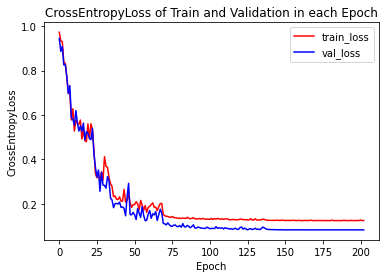

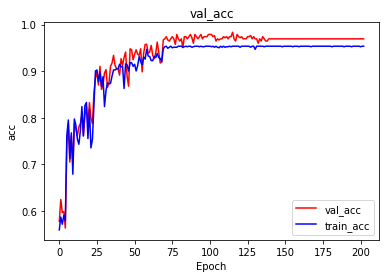

In [177]:
model = Model(batch_size=8, num_workers=0, seed=0,save = True)


model.train(lr=0.001, epochs=800, device='cuda', wait=50, lrd=True, fig_name='test')


model.test()

In [5]:
model2 = Model(batch_size=8, num_workers=0, seed=0, save = False)
model2.net = Net().to('cuda')
state_dict = torch.load('net.pth')
model2.net.load_state_dict(state_dict['model'])
print(f"val acc : {model2.test()}")


val acc : 0.9693396226415094


In [179]:
print(model2.net)

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): ReLU()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): Linear(in_features=100, out_features=10, bias=True)
    (19): ReLU()
    (20): Linear(in_features=10, out_features=3, bias=True)
  )
)
